# Deep Convolutional Generative Adversarial Network

### Importamos TensorFlow y otras librerías

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.7.0'

In [3]:
# Generación de GIFs
!pip install -q imageio

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargamos y preparamos el dataset

Vamos a utilizar el dataset CIFAR para entrenar el generador y el discriminador.

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [6]:
tfds.list_builders()
builder = tfds.builder("cifar10")
builder.download_and_prepare()

In [7]:
print(builder.info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [8]:
(train_dataset_raw) = builder.as_dataset(split="train", as_supervised=True)

In [9]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  # scale from [0,255] to [-1,1]
  image = (image - 127.5) / 127.5
  image = tf.image.resize(image, (32, 32))
  return image, label

In [10]:
train_dataset = train_dataset_raw.map(format_example)

tf.Tensor(
[[[ 0.12156863 -0.24705882 -0.4509804 ]
  [ 0.10588235 -0.24705882 -0.43529412]
  [ 0.05882353 -0.27058825 -0.43529412]
  ...
  [-0.24705882 -0.70980394 -0.8509804 ]
  [-0.1764706  -0.67058825 -0.85882354]
  [-0.18431373 -0.7019608  -0.84313726]]

 [[ 0.00392157 -0.23137255 -0.2784314 ]
  [ 0.14509805 -0.07450981 -0.12156863]
  [ 0.33333334  0.13725491  0.08235294]
  ...
  [-0.15294118 -0.64705884 -0.79607844]
  [-0.12156863 -0.654902   -0.8117647 ]
  [-0.12156863 -0.6784314  -0.827451  ]]

 [[-0.27058825 -0.45882353 -0.4117647 ]
  [-0.07450981 -0.24705882 -0.20784314]
  [ 0.40392157  0.25490198  0.27058825]
  ...
  [ 0.00392157 -0.46666667 -0.6313726 ]
  [-0.01960784 -0.52156866 -0.67058825]
  [-0.04313726 -0.5372549  -0.69411767]]

 ...

 [[ 0.46666667  0.1764706  -0.03529412]
  [ 0.44313726  0.16078432 -0.03529412]
  [ 0.40392157  0.11372549 -0.05098039]
  ...
  [ 0.5529412   0.2784314   0.03529412]
  [ 0.5764706   0.3019608   0.05882353]
  [ 0.62352943  0.3647059   0.121

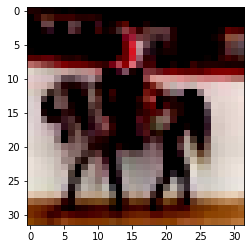

In [11]:
for image, label in train_dataset.take(1):
  print(image)
  plt.imshow(image, interpolation='nearest')

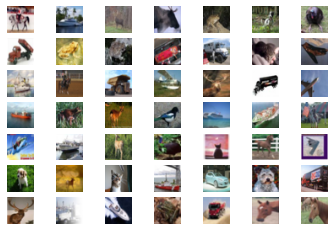

In [12]:
i = 0
for image, label in train_dataset.take(49):
  # define subplot
  plt.subplot(7, 7, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = (image + 1) / 2.0
  plt.imshow(image)
  i = i + 1
plt.show()

## Creación de modelos

Tanto el generador como el discriminador van a ser definidos usando la [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### El generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (upsampling) para producir una imágen a partir de una semilla (ruido aleatorio). Comienza con una capa `Dense`que toma la semilla como entrada, después la escala (upsample) varias veces hasta alcanzar el tamaño de imágen deseado de 32x32x3. Utilizaremos capas de activación `tf.keras.layers.LeakyReLU`, excepto para la capa de salida, que usará tanh.

In [13]:
def make_generator_model():
    # TODO1: Pon aquí tu código

    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    #Tamaño resultante: 8x8x256
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #Tamaño resultante: 8x8x128
    assert model.output_shape == (None, 8,8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #Tamaño resultante: 16x16x64
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #Tamaño resultante final: 32x32x3 
    assert model.output_shape == (None, 32, 32, 3)

    
    return model

In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

Utiliza el generador (aún sin entrenar) para crear una imágen.

In [15]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

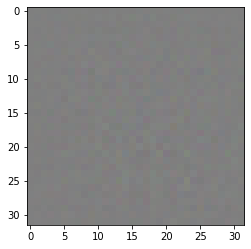

In [16]:
plt.imshow((generated_image[0, :, :, :] + 1) / 2)

### El discriminador

El discriminador es un clasificador de imágenes basado en CNNs.

In [17]:
def make_discriminator_model():
    # TODO2: Pon aquí tu código
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    #Tamaño resultante: 16x16x64
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    #Tamaño resultante: 8x8x128
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    #Aplanamos antes de pasarlo a la capa Dense.
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utiliza el discriminador (aún sin entrenar) para clasificar las imágenes como reales o fake. El modelo se entrenará para sacar valores positivos con imágenes reales y valores negativos con imágenes fake.

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

## Definición de la función de coste y el optimizador

Definimos la función de coste y los optimizadores para ambos modelos.


In [19]:
# Este método devuelve una función helper para calcular cross entropy loss. 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Función de coste del Discriminador

Este método cuantifica cuán bien el dicriminador es capaz de distinguir entre imágenes reales y falsas. Va a comparar las predicciones de imágenes reales con un array de 1s, y las predicciones de imágenes falsas con un array de 0s.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Coste del generador

La función de coste del generador cuantifica cuán bien es capaz de engañar al discriminador. De forma intuitiva, si el generador funciona bien, el descriminador se equivocará. Aquí vamos a comparar las decisiones del discriminador en las imágenes falsas con un array de 1s.

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

El discriminador y el generador tendrán optimizadores separados ya que vamos a entrenar las redes de forma separada.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Guardar checkpoints

Este notebook también demuestra cómo guardar y recuperar modelos, lo que puede ser muy útil en caso de que el entrenamiento se pause o queramos utilizarlo a posteriori.

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definiendo el bucle de entrenamiento

In [24]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 49

# Vamos a reutilizar esta semilla para visualizar mejor el progreso en el GIF.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle de entrenamiento comienza con el generador recibiendo una semilla aleatoria como entrada. Esta semilla se usa para producir una imagen. El discriminador se utiliza después para clasificar imágenes reales (del dataset) e imágenes falsas (producidas por el generador). El coste se calcula para cada una de las redes por separado y se actualizan los pesos mediante descenso por gradiente.

In [25]:
# Aquí utilizamos `tf.function`
# Esto hace que la función se "compile".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      train_step(image_batch)

    # Producimos imágenes para el GIF sobre la marcha
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Guardamos el modelo cada 20 épocas
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generación tras cada época
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

**Generación y guardado de imágenes**


In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Nótese que `training` está marcado como falso.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7,7))

  print(predictions.shape[0])
  for i in range(predictions.shape[0]):
      plt.subplot(7, 7, 1 + i)
      image = (predictions[i, :, :, :] + 1)/ 2.0
      plt.imshow(image)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
#!rm -rf training_checkpoints

## Entrenamos el modelo

Llamamos a la función `train()` definida anteriormente para enrtenar el generador y el discriminador de forma simultanea. Entrenar GANs es complejo, es importante que el generador y el discriminador no aventajen mucho al adversario (ambos deberían entrenar a un ritmo parecido).

Al principio del entrenamiento, las imágenes generadas van a parecer ruido aleatorio. A medida que el entrenamiento progrese, los dígitos generados irán pareciendo cada vez más reales. 

49


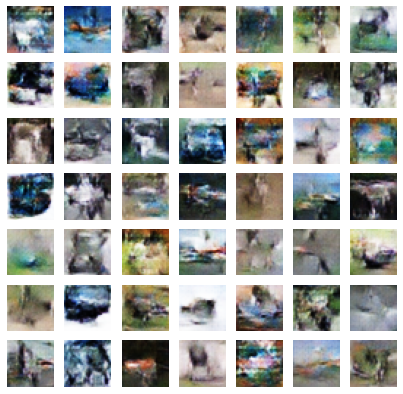

In [29]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset_shuffled = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset_shuffled, EPOCHS)

Reestablecemos el último checkpoint.

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Creamos el GIF


In [31]:
# Muestra de una imágen según el número de época
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

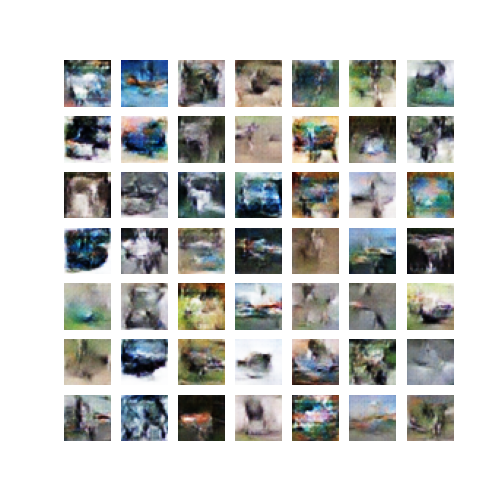

In [32]:
display_image(EPOCHS)

Usamos `imageio` para crear un gif animado con estas imágenes.

In [33]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

Si estás trabajando en Colab, puedes descargar la animación con el siguiente código.

In [34]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>